<a class="anchor" id="0"></a>
# [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression)

### I use the notebook [Higher LB score by tuning mloss (around -6.811)](https://www.kaggle.com/reighns/higher-lb-score-by-tuning-mloss-around-6-811) from [Hongnan Gao](https://www.kaggle.com/reighns) as a basis and will try to tune its various parameters. 

#### From the first attempt, it was possible to improve the LB score

# Acknowledgements

* Ulrich GOUE's Osic-Multiple-Quantile-Regression-Starter
    - Model that uses images can be found at: https://www.kaggle.com/miklgr500/linear-decay-based-on-resnet-cnn
* Michael Kazachok's Linear Decay (based on ResNet CNN)
    - Model that uses tabular data can be found at: https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter
* Replaced Michael's model with EfficientNets B0, B2, B4
* Tuning the parameters of the models from https://www.kaggle.com/reighns/higher-lb-score-by-tuning-mloss 
* https://www.kaggle.com/leoisleo1/efficientnets-quantile-regression-inference
* https://www.kaggle.com/khoongweihao/efficientnets-quantile-regression-inference

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Import libraries](#1)
1. [My upgrade](#2)
    -  [Commit now](#2.1)
    -  [Previous commits](#2.2)
    -  [Parameters and LB score visualization](#2.3)
1. [Download data, auxiliary functions and model tuning](#3)
1. [Prediction and submission](#4)
    -  [Average prediction](#4.1)
    -  [Osic-Multiple-Quantile-Regression](#4.2)
    -  [The change of mloss](#4.3) 
    -  [Ensemble and blending](#4.4)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=f019a987e11814c783a5ffd99315ef2ee3f28aa8655a5d69b290d1b6b100a14f
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=b7bec9064575745c87a2e676b8e8fd51e3e36470786f77b4869418dcd53b140a
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image

In [3]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
seed_everything(42)

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## 2. My upgrade <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

## 2.1. Commit now <a class="anchor" id="2.1"></a>

[Back to Table of Contents](#0.1)

In [6]:
Dropout_model = 0.38
FVC_weight = 0.21
Confidence_weight = 0.21

## 2.2 Previous commits <a class="anchor" id="2.2"></a>

[Back to Table of Contents](#0.1)

In [7]:
commits_df = pd.DataFrame(columns = ['commit_num', 'FVC_weight', 'Dropout_model', 'LB_score', 'seed'])

### seed_everything
* Commits 1-21, 24...: seed_everything = 42
* Commit 23: seed_everything = 0

### Commit 1 (parameters from https://www.kaggle.com/reighns/higher-lb-score-by-tuning-mloss)

* Dropout_model = 0.4
* FVC_weight = 0.25
* Confidence_weight = 0.26

LB = -6.8111

In [8]:
n=0
commits_df.loc[n,'commit_num'] = 1
commits_df.loc[n,'Dropout_model'] = 0.4
commits_df.loc[n,'FVC_weight'] = 0.25
commits_df.loc[n,'LB_score'] = -6.8111

### Commit 4

* Dropout_model = 0.36
* FVC_weight = 0.25
* Confidence_weight = 0.26

LB = -6.8105

In [9]:
n=1
commits_df.loc[n,'commit_num'] = 4
commits_df.loc[n,'Dropout_model'] = 0.36
commits_df.loc[n,'FVC_weight'] = 0.25
commits_df.loc[n,'LB_score'] = -6.8105

### Commit 6

* Dropout_model = 0.36
* FVC_weight = 0.35
* Confidence_weight = 0.36

LB = -6.8158

In [10]:
n=2
commits_df.loc[n,'commit_num'] = 6
commits_df.loc[n,'Dropout_model'] = 0.36
commits_df.loc[n,'FVC_weight'] = 0.35
commits_df.loc[n,'LB_score'] = -6.8158

### Commit 8

* Dropout_model = 0.35
* FVC_weight = 0.25
* Confidence_weight = 0.26

LB = -6.8107

In [11]:
n=3
commits_df.loc[n,'commit_num'] = 8
commits_df.loc[n,'Dropout_model'] = 0.35
commits_df.loc[n,'FVC_weight'] = 0.25
commits_df.loc[n,'LB_score'] = -6.8107

### Commit 9

* Dropout_model = 0.35
* FVC_weight = 0.3
* Confidence_weight = 0.3

LB = -6.8125

In [12]:
n=4
commits_df.loc[n,'commit_num'] = 9
commits_df.loc[n,'Dropout_model'] = 0.35
commits_df.loc[n,'FVC_weight'] = 0.3
commits_df.loc[n,'LB_score'] = -6.8125

### Commit 10

* Dropout_model = 0.36
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8089

In [13]:
n=5
commits_df.loc[n,'commit_num'] = 10
commits_df.loc[n,'Dropout_model'] = 0.36
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8089

### Commit 11

* Dropout_model = 0.36
* FVC_weight = 0.15
* Confidence_weight = 0.15

LB = -6.8100

In [14]:
n=6
commits_df.loc[n,'commit_num'] = 11
commits_df.loc[n,'Dropout_model'] = 0.36
commits_df.loc[n,'FVC_weight'] = 0.15
commits_df.loc[n,'LB_score'] = -6.8100

### Commit 13

* Dropout_model = 0.36
* FVC_weight = 0.175
* Confidence_weight = 0.175

LB = -6.8096

In [15]:
n=7
commits_df.loc[n,'commit_num'] = 13
commits_df.loc[n,'Dropout_model'] = 0.36
commits_df.loc[n,'FVC_weight'] = 0.175
commits_df.loc[n,'LB_score'] = -6.8096

### Commit 14

* Dropout_model = 0.36
* FVC_weight = 0.225
* Confidence_weight = 0.225

LB = -6.8100

In [16]:
n=8
commits_df.loc[n,'commit_num'] = 14
commits_df.loc[n,'Dropout_model'] = 0.36
commits_df.loc[n,'FVC_weight'] = 0.225
commits_df.loc[n,'LB_score'] = -6.8100

### Commit 15

* Dropout_model = 0.32
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8092

In [17]:
n=9
commits_df.loc[n,'commit_num'] = 15
commits_df.loc[n,'Dropout_model'] = 0.32
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8092

### Commit 16

* Dropout_model = 0.25
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8093

In [18]:
n=10
commits_df.loc[n,'commit_num'] = 16
commits_df.loc[n,'Dropout_model'] = 0.25
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8093

### Commit 17

* Dropout_model = 0.25
* FVC_weight = 0.5
* Confidence_weight = 0.5

LB = -6.8283

In [19]:
n=11
commits_df.loc[n,'commit_num'] = 17
commits_df.loc[n,'Dropout_model'] = 0.25
commits_df.loc[n,'FVC_weight'] = 0.5
commits_df.loc[n,'LB_score'] = -6.8283

### Commit 18

* Dropout_model = 0.38
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8087

In [20]:
n=12
commits_df.loc[n,'commit_num'] = 18
commits_df.loc[n,'Dropout_model'] = 0.38
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8087

### Commit 19

* Dropout_model = 0.39
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8090

In [21]:
n=13
commits_df.loc[n,'commit_num'] = 19
commits_df.loc[n,'Dropout_model'] = 0.39
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8090

### Commit 20

* Dropout_model = 0.37
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8092

In [22]:
n=14
commits_df.loc[n,'commit_num'] = 20
commits_df.loc[n,'Dropout_model'] = 0.37
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8092

### Commit 21

* Dropout_model = 0.38
* FVC_weight = 0.19
* Confidence_weight = 0.19

LB = -6.8093

In [23]:
n=15
commits_df.loc[n,'commit_num'] = 21
commits_df.loc[n,'Dropout_model'] = 0.38
commits_df.loc[n,'FVC_weight'] = 0.19
commits_df.loc[n,'LB_score'] = -6.8093

### Commit 23

* Dropout_model = 0.38
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8402

In [24]:
n=16
commits_df.loc[n,'commit_num'] = 23
commits_df.loc[n,'Dropout_model'] = 0.38
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8402

### Commit 26

* Dropout_model = 0.385
* FVC_weight = 0.2
* Confidence_weight = 0.2

LB = -6.8092

In [25]:
n=17
commits_df.loc[n,'commit_num'] = 26
commits_df.loc[n,'Dropout_model'] = 0.385
commits_df.loc[n,'FVC_weight'] = 0.2
commits_df.loc[n,'LB_score'] = -6.8092

## 2.3 Parameters and LB score visualization <a class="anchor" id="2.3"></a>

[Back to Table of Contents](#0.1)

In [26]:
# Find and mark maximum value of LB score
commits_df['LB_score'] = pd.to_numeric(commits_df['LB_score'])
commits_df['max'] = 0
commits_df.loc[commits_df['LB_score'].idxmax(), 'max'] = 1

In [27]:
# Seed
commits_df['seed'] = 42
commits_df.loc[commits_df['commit_num'] == 23, 'seed'] = 0

In [28]:
commits_df

,commit_num,FVC_weight,Dropout_model,LB_score,seed,max
0,1,0.25,0.4,-6.8111,42,0
1,4,0.25,0.36,-6.8105,42,0
2,6,0.35,0.36,-6.8158,42,0
3,8,0.25,0.35,-6.8107,42,0
4,9,0.3,0.35,-6.8125,42,0
5,10,0.2,0.36,-6.8089,42,0
6,11,0.15,0.36,-6.8100,42,0
7,13,0.175,0.36,-6.8096,42,0
8,14,0.225,0.36,-6.8100,42,0
9,15,0.2,0.32,-6.8092,42,0


In [29]:
# Interactive plot with results of parameters tuning
fig = px.scatter_3d(commits_df, x='FVC_weight', y='Dropout_model', z='LB_score', color = 'max', 
                    symbol = 'seed',
                    title='Parameters and LB score visualization of OSIC PFP solutions')
fig.update(layout=dict(title=dict(x=0.1)))

Other parameters should be changed to increase accuracy.

## 3. Download data, auxiliary functions and model tuning <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [30]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

In [31]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [32]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [33]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [34]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [35]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
    model.load_weights('../input/osic-model-weights/' + weights)
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [36]:
tr_p, vl_p = train_test_split(P, shuffle=True, train_size = 0.8) 

In [37]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [38]:
subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

6.7386115244278315
6.7386157849118185
6.738613409663092
6.738611777632042
6.738608976510854
6.73860117497328
6.738588805611822
6.738575478981084
6.73858318263184



## 4. Prediction and submission <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

## 4.1 Average prediction <a class="anchor" id="4.1"></a>

[Back to Table of Contents](#0.1)

In [39]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [40]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3092.863664,143.050520
1,ID00421637202311550012437_-12,2847.459621,190.504912
2,ID00422637202311677017371_-12,2002.654819,149.327313
3,ID00423637202312137826377_-12,3410.692459,195.951362
4,ID00426637202313170790466_-12,2971.430485,118.255453


In [41]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [42]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

## 4.2 Osic-Multiple-Quantile-Regression <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [43]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [44]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [45]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [46]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [47]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [48]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [49]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [50]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [51]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [52]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

## 4.3 The change of mloss <a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [53]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [54]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [55]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [56]:
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

In [57]:
%%time
cnt = 0
EPOCHS = 800
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [34.26871871948242, 6.513584136962891]
val [40.77041244506836, 6.815109729766846]
predict val...
predict test...
FOLD 2
train [32.534976959228516, 6.466352939605713]
val [46.84785461425781, 6.927820682525635]
predict val...
predict test...
FOLD 3
train [31.752376556396484, 6.432339668273926]
val [48.342769622802734, 6.778236389160156]
predict val...
predict test...
FOLD 4
train [34.671234130859375, 6.537336826324463]
val [35.4522705078125, 6.5579094886779785]
predict val...
predict test...
FOLD 5
train [31.711185455322266, 6.435805320739746]
val [40.830562591552734, 6.774467468261719]
predict val...
predict test...
CPU times: user 4min 33s, sys: 16.4 s, total: 4min 49s
Wall time: 4min 6s


In [58]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

147.54423979221804 230.28511414170654


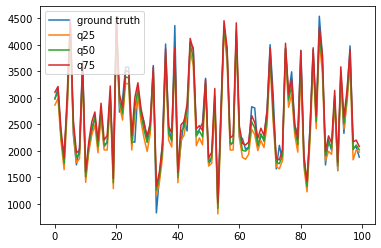

In [59]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [60]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

12.16650390625 230.28511414170654 385.734375 1.0


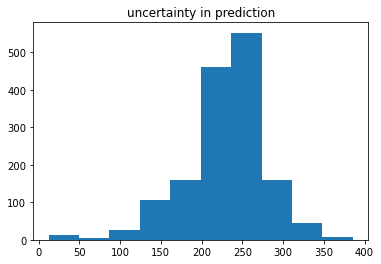

In [61]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [62]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [63]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2868.506897,235.997925
1541,ID00419637202311204720264_-11,3020,100.0,2866.019836,237.181458
1542,ID00419637202311204720264_-10,3020,100.0,2863.532959,238.364929
1543,ID00419637202311204720264_-9,3020,100.0,2861.045959,239.548645
1544,ID00419637202311204720264_-8,3020,100.0,2858.558960,240.732117
1545,ID00419637202311204720264_-7,3020,100.0,2856.072021,241.915771
1546,ID00419637202311204720264_-6,3020,100.0,2853.585205,243.099487
1547,ID00419637202311204720264_-5,3020,100.0,2851.098206,244.282898
1548,ID00419637202311204720264_-4,3020,100.0,2848.611206,245.466553
1549,ID00419637202311204720264_-3,3020,100.0,2846.124207,246.649841


In [64]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [65]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2868.506897,235.997925,2868.506897,235.997925
1541,ID00419637202311204720264_-11,2866.019836,237.181458,2866.019836,237.181458
1542,ID00419637202311204720264_-10,2863.532959,238.364929,2863.532959,238.364929
1543,ID00419637202311204720264_-9,2861.045959,239.548645,2861.045959,239.548645
1544,ID00419637202311204720264_-8,2858.558960,240.732117,2858.558960,240.732117


In [66]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2641.222659,329.968662,1954.084534,2583.998199,2686.490753,2821.747696,3209.278259
Confidence,730.0,285.447498,46.539541,183.962708,249.529610,285.468948,322.977737,375.795715
FVC1,730.0,2641.222659,329.968662,1954.084534,2583.998199,2686.490753,2821.747696,3209.278259
Confidence1,730.0,285.447498,46.539541,183.962708,249.529610,285.468948,322.977737,375.795715


In [67]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [68]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [69]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

## 4.4 Ensemble and blending <a class="anchor" id="4.4"></a>

[Back to Table of Contents](#0.1)

In [70]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [71]:
df = df1[['Patient_Week']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2884.659245,217.413370
1,ID00419637202311204720264_-10,2909.992255,216.648751
2,ID00419637202311204720264_-11,2912.806964,216.563884
3,ID00419637202311204720264_-12,2915.621818,216.478970
4,ID00419637202311204720264_-2,2887.474050,217.328407


In [72]:
df.to_csv('submission.csv', index=False)

[Go to Top](#0)